# Rectangle counting

In this notebook a neural network is used to correctly guess the numbre of vehicles in an image. The structure is as follows:

* input: image with vehicles
* output: number of vehicles per image

<br>

Let's start first with the imports.

In [2]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

from keras.models import Sequential, model_from_json
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense, Dropout, Activation

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 1) Data creation

In [3]:
# Main variables
num_imgs = 40000
img_size = 200
min_num_figs = 0
max_num_figs = 29 # (included)
w_1, h_1 = 4, 2
w_2, h_2 = 21, 3
version = 'v1' # to be added when saving data

In [4]:
# To avoid having vehicles overlapping each other we divided the image into a grid
grid = 6
grid_length = img_size / grid

possible_positions = [(x, y) for x in range(grid) for y in range(grid)]

In [5]:
# Function to create the circles
def create_imgs(num_imgs):
    
    # Arrays to store the figure as a matrix with white background (0) and the figure drawn in black (1)
    imgs_input = np.zeros((num_imgs, img_size, img_size))  # input
    vals_output = np.zeros((num_imgs, int(np.ceil(max_num_figs / 10)))) # output
    exact_number_of_figs_output = np.zeros(num_imgs)
    
    # Main loop for each image
    for i_img in range(num_imgs):
        
        if i_img % 5000 == 0: # to visualize progress
            print(i_img)
            
        num_figures = np.random.randint(min_num_figs, max_num_figs + 1)
        vals_output[i_img, int(np.floor(num_figures / 10))] = 1 # we save the number of figures
        exact_number_of_figs_output[i_img] = num_figures # we save the number of figures
        
        # Index of the small area in grid
        np.random.shuffle(possible_positions)
        
        for i_fig in range(num_figures):
            
            if i_fig < max_num_figs:
                (i, j) = possible_positions[i_fig]
            else:
                (i, j) = np.random.choice(possible_positions)
        
            # To select between the two possible sizes
            one_or_two = np.random.choice([1, 2])
            
            # Width and height parameters
            if one_or_two == 1:
                w, h = w_1, h_1
            elif one_or_two == 2:
                w, h = w_2, h_2
            
            # Angle 
            th = 0 # (now set to zero)
            c, s = np.cos(th), np.sin(th)
            
            # Position of the first point (we try to make sure that the rectangle is inside the image)
            x = np.random.randint(grid_length * i, grid_length * (i + 1) - w)
            y = np.random.randint(grid_length * j, grid_length * (j + 1) - h)
            
            # To draw the rectangle with ones inside the matrix (imgs) we need to calculate the 4 corners of the rectangle
            xA, yA = x, y
            xB, yB = x + w, y
            xC, yC = x + w, y + h
            xD, yD = x, y + h
            
            # We get the min and max values for the loop that will fill with ones the position of the rectangle in the matrix 
            min_x, max_x = int(np.ceil(min(xA, xB, xC, xD))), int(np.floor(max(xA, xB, xC, xD)))
            min_y, max_y = int(np.ceil(min(yA, yB, yC, yD))), int(np.floor(max(yA, yB, yC, yD)))
            
            # The rectangle is drawn in the imgs matrix
            for i_x in range(max(0, min_x), min(img_size, max_x)): # We fix the limits between 0 and img_size
                for i_y in range(max(0, min_y), min(img_size, max_y)):
            
                    # To build the rectangle we use the equations of the 4 lines that build it
                    if (i_y - yA >= (i_x - xA) * np.tan(th)) and (i_y - yC <= (i_x - xC) * np.tan(th)) and \
                    (i_y - yA >= (i_x - xA) * np.tan(th - np.pi / 2)) and (i_y - yB <= (i_x - xB) * np.tan(th - np.pi / 2)):
                        imgs_input[i_img, i_x, i_y] = 1. # We place a 1 if the x, y point is inside the rectangle
            
    return imgs_input, vals_output, exact_number_of_figs_output

In [6]:
imgs_input, vals_output, exact_number_of_figs_output = create_imgs(num_imgs)

0
5000
10000
15000
20000
25000
30000
35000


We can now plot several figures to see them on the notebook.

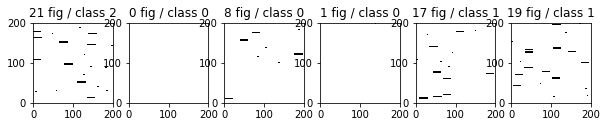

In [7]:
# We now plot several of the created figures
plt.figure(figsize=(10, 10))
for i in range(1, 7):
    r = np.random.randint(0, num_imgs)
    plt.subplot(1, 6, i)
    plt.imshow(imgs_input[r].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    plt.title(str(int(exact_number_of_figs_output[r])) + ' fig / class ' + str(vals_output[r].argmax()))
plt.show()

In [8]:
# Image warping
import cv2

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

warped_size = 50
warped_imgs_input = np.zeros((num_imgs, warped_size, warped_size))
for i in range(num_imgs):
    warped_imgs_input[i] = image_resize(imgs_input[i], height = warped_size).T

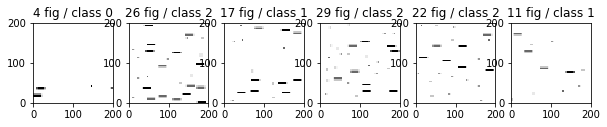

In [10]:
# We now plot several of the created figures
plt.figure(figsize=(10, 10))
for i in range(1, 7):
    r = np.random.randint(0, num_imgs)
    plt.subplot(1, 6, i)
    plt.imshow(warped_imgs_input[r], cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    plt.title(str(int(exact_number_of_figs_output[r])) + ' fig / class ' + str(vals_output[r].argmax()))
plt.show()

### 2) Creation of the neural network

Here we define:

1. The main parameters
1. A function to separate between train ant test (split must be predefined)
1. A function to create the neural network

In [12]:
# Neural network parameters
split = 0.8 # (= train/total)
n_epochs = 25
init_lr = 1e-3 # initial learning rate
bs = 32 # batch size
loss_fun = 'categorical_crossentropy'

In [13]:
# Data scaling and data partition into training and testing sets
def create_train_test_sets(imgs_input, vals_output, split):
    
    X = imgs_input
    num_imgs = X.shape[0] # number of figures
    y = vals_output
    
    # Split into training and test sets:
    i = int(split * num_imgs)
    train_X = X[:i]
    test_X = X[i:]
    train_y = y[:i]
    test_y = y[i:]
    
    # Adapt the shapes for the CNN (input)
    train_X = train_X.reshape(train_X.shape + (1,))
    test_X = test_X.reshape(test_X.shape + (1,))
    
    return train_X, test_X, train_y, test_y

In [14]:
# Creation of the neural network
def build_nn(input_shape, output_shape):
    
    filter_size = 3
    pool_size = 2
    model = Sequential([
        Conv2D(32, (6, 6), input_shape=input_shape, activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(64, (filter_size, filter_size), activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(128, (filter_size, filter_size), activation='relu'), 
        Conv2D(128, (filter_size, filter_size), activation='relu'), 
        Flatten(), 
        Dropout(0.4), 
        Dense(50, activation='relu'), 
        Dropout(0.4), 
        Dense(output_shape, activation='softmax')
    ])
    
    return model

### 3) Network training and predictions

In [15]:
# We divide the data into x and y train and test sets
[x_train, x_test, y_train, y_test] = create_train_test_sets(warped_imgs_input, vals_output, split)

In [16]:
input_shape = x_train[-1].shape
output_shape = vals_output.shape[1]

model = build_nn(input_shape, output_shape)
model.compile(loss = loss_fun, optimizer = 'adadelta',  metrics = ['accuracy'])      
model.fit(x_train, y_train, batch_size = bs, epochs = n_epochs, verbose = 1, validation_split = 0.15)

Train on 27200 samples, validate on 4800 samples
Epoch 1/25
27200/27200 [==============================] - 180s 7ms/step - loss: 0.4564 - acc: 0.7960 - val_loss: 0.2649 - val_acc: 0.8896
Epoch 2/25
27200/27200 [==============================] - 175s 6ms/step - loss: 0.2685 - acc: 0.8863 - val_loss: 0.1715 - val_acc: 0.9271
Epoch 3/25
27200/27200 [==============================] - 183s 7ms/step - loss: 0.2220 - acc: 0.9090 - val_loss: 0.1530 - val_acc: 0.9346
Epoch 4/25
27200/27200 [==============================] - 187s 7ms/step - loss: 0.1997 - acc: 0.9178 - val_loss: 0.2055 - val_acc: 0.9042
Epoch 5/25
27200/27200 [==============================] - 192s 7ms/step - loss: 0.1779 - acc: 0.9260 - val_loss: 0.1349 - val_acc: 0.9396
Epoch 6/25
27200/27200 [==============================] - 175s 6ms/step - loss: 0.1685 - acc: 0.9308 - val_loss: 0.1316 - val_acc: 0.9448
Epoch 7/25
27200/27200 [==============================] - 179s 7ms/step - loss: 0.1580 - acc: 0.9357 - val_loss: 0.1300 - v

In [19]:
# Evaluation
pred_y = model.predict(x_test)

[loss_train, acc_train] = model.evaluate(x = x_train, y = y_train, verbose = 0)
[loss_test, acc_test] = model.evaluate(x = x_test, y = y_test, verbose = 0)

n_param = model.count_params()

### 4) Results

In [20]:
print('loss_train:', loss_train)
print('acc_train:', acc_train)
print('loss_test:', loss_test)
print('acc_test:', acc_test)
print('n_param:', n_param)

loss_train: 0.03873352728759346
acc_train: 0.98953125
loss_test: 0.23087115354009438
acc_test: 0.94025
n_param: 471723


In [21]:
test_size = pred_y.shape[0]
possible_num_figs = pred_y.shape[1]
test_figs = np.asarray(x_test).reshape((x_test.shape[0:3]))
# We transform the result vector to 1 and 0
results = np.zeros((test_size, possible_num_figs))
for i in range(test_size):
    aux = np.argmax(pred_y[i])
    results[i, aux] = 1

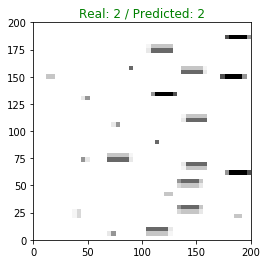

In [32]:
# Visualization
a = np.random.randint(0, test_size)
plt.imshow(test_figs[a], cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
real_num_figs = np.argmax(y_test[a])
predicted_num_figs = np.argmax(results[a])
title_obj = plt.title('Real: ' + str(real_num_figs) + ' / Predicted: ' + str(predicted_num_figs))
if real_num_figs != predicted_num_figs:
    plt.setp(title_obj, color='r')
else:
    plt.setp(title_obj, color='g')

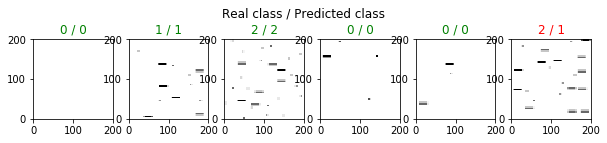

In [37]:
# We now plot several of the created figures
plt.figure(figsize=(10, 2.1))
plt.suptitle('Real class / Predicted class')
for i in range(1, 7):
    a = np.random.randint(0, test_size)
    plt.subplot(1, 6, i)
    plt.imshow(test_figs[a], cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    real_num_figs = np.argmax(y_test[a])
    predicted_num_figs = np.argmax(results[a])
    title_obj = plt.title(str(real_num_figs) + ' / ' + str(predicted_num_figs))
    if real_num_figs != predicted_num_figs:
        plt.setp(title_obj, color='r')
    else:
        plt.setp(title_obj, color='g')
plt.show()

In [38]:
# Save in a pdf
sample_size = 50

pdf_path_name = 'myPath/myPDFName.pdf'

with PdfPages('pdf_path_name') as pdf: # We open the pdf file

    for i in range(sample_size):
        plt.imshow(test_figs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
        real_num_figs = np.argmax(y_test[i])
        predicted_num_figs = np.argmax(results[i])
        title_obj = plt.title('Real: ' + str(real_num_figs) + ' / Predicted: ' + str(predicted_num_figs))
        if real_num_figs != predicted_num_figs:
            plt.setp(title_obj, color='r')
        else:
            plt.setp(title_obj, color='g')
        pdf.savefig()
        plt.close()

### 5) Validation

Information is saved to a text file.

##### 5.1) Confusion matrix

In [39]:
from tabulate import tabulate

num_classes = pred_y.shape[1]

print('Validation for version: ' + version,  file = f)
print('No colour / No angle / Output as classes of groups of ten', file = f)
print('\n', file = f)

In [40]:
TPR, FPR = np.zeros(num_classes), np.zeros(num_classes)
for i_class in range(num_classes):
    TP, FP, TN, FN = 0, 0, 0, 0
    cond_true, cond_false = 0, 0
    for i in range(test_size):
        if pred_y[i].argmax() == i_class and y_test[i].argmax() == i_class:
            TP += 1
            cond_true += 1
        elif pred_y[i].argmax() == i_class and y_test[i].argmax() != i_class:
            FP += 1
            cond_false += 1
        elif pred_y[i].argmax() != i_class and y_test[i].argmax() != i_class:
            TN += 1
            cond_false += 1
        else:
            FN += 1
            cond_true += 1
    TPR[i_class] = TP / cond_true
    FPR[i_class] = FP / cond_false

    print(tabulate([['pred is class', 'TP = '+ str(TP), 'FP = '+ str(FP)], 
                    ['pred is other class', 'FN = '+ str(FN), 'TN = '+ str(TN)]], 
                   headers=['CLASS ' + str(i_class), 'is class', 'is other class'], tablefmt='orgtbl'))
    print('\n')

    # We print in the .txt file too
    print(tabulate([['pred is class', 'TP = '+ str(TP), 'FP = '+ str(FP)], 
                    ['pred is other class', 'FN = '+ str(FN), 'TN = '+ str(TN)]], 
                   headers=['CLASS ' + str(i_class), 'is class', 'is other class'], tablefmt='orgtbl'), file = f)
    print('\n', file = f)

| CLASS 0             | is class   | is other class   |
|---------------------+------------+------------------|
| pred is class       | TP = 2658  | FP = 115         |
| pred is other class | FN = 74    | TN = 5153        |


| CLASS 1             | is class   | is other class   |
|---------------------+------------+------------------|
| pred is class       | TP = 2335  | FP = 203         |
| pred is other class | FN = 275   | TN = 5187        |


| CLASS 2             | is class   | is other class   |
|---------------------+------------+------------------|
| pred is class       | TP = 2529  | FP = 160         |
| pred is other class | FN = 129   | TN = 5182        |




In [41]:
specificity = TPR
sensitivity = 1 - FPR

print('TPR = ', TPR)
print('FPR = ', FPR)
print('specificity = ', specificity)
print('sensitivity = ', sensitivity)


print('\n', file = f)
print('TPR = ', TPR, file = f)
print('FPR = ', FPR, file = f)
print('specificity = ', specificity, file = f)
print('sensitivity = ', sensitivity, file = f)

TPR =  [0.97291362 0.89463602 0.95146727]
FPR =  [0.02182992 0.03766234 0.02995133]
specificity =  [0.97291362 0.89463602 0.95146727]
sensitivity =  [0.97817008 0.96233766 0.97004867]


##### 5.2) ROC curve

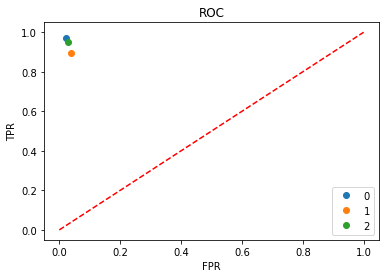

In [42]:
import matplotlib.pyplot as plt

for i in range(num_classes):
    plt.plot(FPR[i], TPR[i], 'o')
plt.plot([0,1], 'r--')
plt.legend(range(num_classes))
plt.title('ROC')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [43]:
# ROC curve based on a threshold
TPR, FPR = np.zeros((num_classes, 10)), np.zeros((num_classes, 10))
for i_class in range(num_classes):
    for pos in range(0, 10):
        threshold = pos / 10
        TP, FP, TN, FN = 0, 0, 0, 0
        cond_true, cond_false = 0, 0
        for i in range(test_size):
            if pred_y[i, i_class] >= threshold:
                if y_test[i, i_class] == 1:
                    TP += 1
                    cond_true += 1
                else: 
                    FP += 1
                    cond_false += 1
            else:
                if y_test[i, i_class] == 1:
                    FN += 1
                    cond_true += 1
                else: 
                    TN += 1
                    cond_false += 1

        TPR[i_class, pos] = TP / cond_true
        FPR[i_class, pos] = FP / cond_false

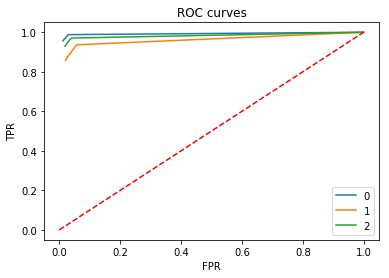

In [44]:
for i in range(num_classes):
    plt.plot(FPR[i], TPR[i])
plt.plot([0,1], 'r--')
plt.title('ROC curves')
plt.legend(range(num_classes))
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

##### 5.3) Probability analysis

To evaluate the accuracy of the probabilities predicted.

In [45]:
# Mean probability when right
probas = np.zeros(num_classes)
for i_class in range(num_classes):
    for i in range(test_size):
        pred_class = pred_y[i].argmax()
        if pred_class == y_test[i].argmax():
            probas[pred_class] += pred_y[i, pred_class]
probas /= test_size
probas

print('\n', file = f)
print('Mean probability when right = ', probas, file = f)

In [49]:
probas

array([0.99172215, 0.86288073, 0.94073505])

In [46]:
# mean of difference of probability and next biggest proba when right
def second_largest(numbers):
    count = 0
    m1 = m2 = float('-inf')
    for x in numbers:
        count += 1
        if x > m2:
            if x >= m1:
                m1, m2 = x, m1            
            else:
                m2 = x
    return m2 if count >= 2 else None

diff_probas = np.zeros(num_classes)
for i_class in range(num_classes):
    for i in range(test_size):
        pred_class = pred_y[i].argmax()
        if pred_class == y_test[i].argmax():
            diff_probas[pred_class] += (pred_y[i, pred_class] - second_largest(pred_y[i]))
diff_probas /= test_size
diff_probas

print('\n', file = f)
print('Mean of difference between probability and second biggest when right = ', diff_probas, file = f)

In [47]:
diff_probas

array([0.9866943 , 0.85013646, 0.9330951 ])